
# Stock Market Prediction Pipeline

- Load and preprocess stock data.
- Apply various anomaly detection models.
- Extract features and use Chronos for embeddings.
- Make time series predictions.
- Compare results against actual stock prices.

## Pipeline Overview
1. **Data Ingestion & Preprocessing**
2. **Anomaly Detection (SOTA Models)**
3. **Feature Engineering (Chronos Embeddings & Indicators)**
4. **Modeling & Prediction (Chronos for Time Series)**
5. **Evaluation & Comparison (Backtesting & Visualization)**


## magic numberlist

1. mooving avrages. 12MA 24MA.
2. amount of past data. 15 years.
3. prediction window 64
4. chronos model decision. t5-tiny
5. iforest params
6. threshold for predicted 0's as anomalies

## 1. Data Ingestion & Preprocessing

In [ ]:
import os

# Define the directories
directories = ["stock_data", "stock_predictions"]

# Create directories if they do not exist
for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)

In [1]:
! pip install yfinance==0.2.37 -q  # Install specific version


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf

class DataLoader:
    def __init__(self, tickers, start_date, end_date):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date

    def load_data(self):
        data = {}
        for ticker in self.tickers:
            df = yf.download(ticker, start=self.start_date, end=self.end_date)[["Close"]].copy()
            
            #implement RSI
            window = 14
            delta = df["Close"].diff()
            gain = (delta.where(delta > 0, 0)).copy()
            loss = (-delta.where(delta < 0, 0)).copy()
            avg_gain = gain.rolling(window=window).mean()
            avg_loss = loss.rolling(window=window).mean()
            rs = avg_gain / avg_loss
            df["RSI"] = 100 - (100 / (1 + rs))
            
            # if rsi just crossed below 30 yesterday it was above and today it is below indicating a Indicator signal
            df["Indicator"] = np.where((df["RSI"].shift(1) > 30) & (df["RSI"] < 30), 1, 0)
            # # drop na values
            df.dropna(inplace=True)
            # print sum of indicator signals
            print(f"Stock: {ticker}")
            print(df["Indicator"].sum())
            
            data[ticker] = df
        return data

# Example usage
tickers = ["AAPL", "MSFT", "GOOGL", "KO", "AMZN"]
data_loader = DataLoader(tickers, "2010-01-01", "2025-01-01")
stock_data = data_loader.load_data()

for ticker, df in stock_data.items():
    path = "stock_data"
    df.to_csv(f"{path}/{ticker}.csv")
    # print(f"Stock: {ticker}")
    # print(df["Indicator"].sum())
    # print(df.head())


/Users/mariomattiasulmonte/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## 2. Chronos Forcasting


In [3]:
! pip install chronos-forecasting -q


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
from chronos import ChronosPipeline
import torch
import pandas as pd
from datetime import timedelta

# fetch data from csv folder function 
def load_data(ticker):
    path = "stock_data"
    df = pd.read_csv(f"{path}/{ticker}.csv", index_col=0, parse_dates=True)
    return df
  
# Split data into train and test sets
def train_test_split(df, test_size=64):
    train_data = {}
    test_data = {}
    
    train_data = df.iloc[:-test_size]
    test_data = df.iloc[-test_size:]
    
    return train_data, test_data

def predict(ticker, train_data, test_data, pipeline):

    # Convert training data to tensor
    context = torch.tensor(train_data["Close"].values, dtype=torch.bfloat16)
    prediction_length = len(test_data)

    # Predict
    output = pipeline.predict(
        context=context,
        prediction_length=prediction_length,
        limit_prediction_length=False,
    )

    # Convert output tensor to DataFrame
    output_reshaped = output.cpu().numpy().flatten()
    future_dates = pd.date_range(start=test_data.index[0], periods=prediction_length, freq='B')

    # Ensure all arrays are of the same length
    min_length = min(len(future_dates), len(test_data["Close"].values), len(output_reshaped))
    future_dates = future_dates[:min_length]
    actual_close = test_data["Close"].values[:min_length]
    predicted_close = output_reshaped[:min_length]

    # Create a DataFrame with actual and predicted values
    predictions_df = pd.DataFrame({
        "Date": future_dates,
        "Actual_Close": actual_close,
        "Predicted_Close": predicted_close,
        "Indicator": test_data["Indicator"].values[:min_length]
    })
    output_dir = "stock_predictions"
    
    # Save to CSV
    file_path = f"{output_dir}/{ticker}_predictions.csv"
    predictions_df.to_csv(file_path, index=False)
    print(f"Saved predictions for {ticker} to {file_path}")
     
# Use CUDA if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create Chronos pipeline
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map=device,
    torch_dtype=torch.bfloat16,
)
# automize for all tickers
tickers = ["AAPL", "MSFT", "GOOGL", "KO", "AMZN"]

for ticker in tickers:
    stock_df = load_data(ticker)
    train_data, test_data = train_test_split(stock_df)
    predict(ticker, train_data, test_data, pipeline)


suca
Saved predictions for AAPL to stock_predictions/AAPL_predictions.csv
suca
Saved predictions for MSFT to stock_predictions/MSFT_predictions.csv


KeyboardInterrupt: 

## 3. Anomaly prediction using time intervals

In [14]:
def predict_anomalies(ticker, train_data, test_data, pipeline, threshold=0.1, device=None):
    df = train_data.copy()
    df["Close"] = df["Close"]*df["Indicator"]
    # Convert training data to tensor
    context = torch.tensor(df["Close"].values, dtype=torch.bfloat16)
    prediction_length = len(test_data)

    # Predict
    output = pipeline.predict(
        context=context,
        prediction_length=prediction_length,
        limit_prediction_length=False,
    )

    # Convert output tensor to DataFrame
    output_reshaped = output.cpu().numpy().flatten()
    future_dates = pd.date_range(start=test_data.index[0], periods=prediction_length, freq='B')

    # Ensure all arrays are of the same length
    min_length = min(len(future_dates), len(test_data["Close"].values), len(output_reshaped))
    predicted_anomaly = output_reshaped[:min_length]
    # read the predictions
    predictions_df = pd.read_csv(f"stock_predictions/{ticker}_predictions.csv")
    # add the anomaly predictions to the dataframe, if the predicted value is greater than a threshold, then it is an anomaly
    predictions_df["Chronos_prediction"] = np.where(predicted_anomaly > threshold, 1, 0)
    
    output_dir = "stock_predictions"
    # Save to CSV
    file_path = f"{output_dir}/{ticker}_predictions.csv"
    predictions_df.to_csv(file_path, index=False)
    print(f"Saved predictions for {ticker} to {file_path}")
     
# Use CUDA if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
for ticker in tickers:
    stock_df = load_data(ticker)
    train_data, test_data = train_test_split(stock_df)
    predict_anomalies(ticker, train_data, test_data, pipeline, threshold=0.1)
    
    
    

Saved predictions for AAPL to stock_predictions/AAPL_predictions.csv
Saved predictions for MSFT to stock_predictions/MSFT_predictions.csv
Saved predictions for GOOGL to stock_predictions/GOOGL_predictions.csv
Saved predictions for KO to stock_predictions/KO_predictions.csv
Saved predictions for AMZN to stock_predictions/AMZN_predictions.csv


## 4. Anomaly Detection using the SOTA on predicted data

In [9]:
! pip install pyod -q


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [11]:
from pyod.models.iforest import IForest

def sota_predict(model, ticker, device=None):
    # get data from stock predictions
    path = "stock_predictions"
    stock_predictions = pd.read_csv(f"{path}/{ticker}_predictions.csv")
    
    model.fit(stock_predictions["Predicted_Close"].values.reshape(-1, 1))
    
    # Predict anomalies
    stock_predictions["SOTA_prediction"] = model.predict(stock_predictions["Predicted_Close"].values.reshape(-1, 1))
    
    # Save to CSV
    output_dir = "stock_predictions"
    file_path = f"{output_dir}/{ticker}_predictions.csv"
    stock_predictions.to_csv(file_path, index=False)
    print(f"Saved predictions for {ticker} to {file_path}")
    
# Create IForest model
model = IForest(n_estimators=100, random_state=42)

for ticker in tickers:
    sota_predict(model, ticker,device=device)

Saved predictions for AAPL to stock_predictions/AAPL_predictions.csv
Saved predictions for MSFT to stock_predictions/MSFT_predictions.csv
Saved predictions for GOOGL to stock_predictions/GOOGL_predictions.csv
Saved predictions for KO to stock_predictions/KO_predictions.csv
Saved predictions for AMZN to stock_predictions/AMZN_predictions.csv


## 5.1. Evaluation

In [16]:
# here we will evaluation of the predictions of the chronos model and the sota model
# here we will evaluation of the predictions of the chronos model and the sota model

import glob
from sklearn.metrics import f1_score

# Directory containing your CSV files
DIRECTORY_PATH = "stock_predictions"

# List all CSV files in the directory
csv_files = glob.glob(os.path.join(DIRECTORY_PATH, "*.csv"))

# A list to store results from each file
results = []

for csv_file in csv_files:
  # Read the CSV into a DataFrame
  df = pd.read_csv(csv_file)

  # Make sure the required columns exist in the CSV
  # (in this example, we assume "true_anomaly" is a bool ground-truth column)
  if "Indicator" not in df.columns:
      print(f"Skipping {csv_file}: 'Indicator' column not found.")
      continue

  # Compute F1 scores for each prediction column
  file_results = {"filename": os.path.basename(csv_file)}

  for pred_col in ['Chronos_prediction','SOTA_prediction']:
    # Safety check: ensure the column is boolean or can be interpreted as boolean
    f1 = f1_score(y_true=df["Indicator"], y_pred=df[pred_col])
    file_results[f"F1_{pred_col}"] = f1

  # Append the results for this file
  results.append(file_results)

# Create a summary DataFrame
results_df = pd.DataFrame(results)
# Print or save the summary results
print(results_df)



                filename  F1_Predicted Indicator  F1_SOTA_Anomaly
0   AMZN_predictions.csv                     0.0         0.250000
1   MSFT_predictions.csv                     0.0         0.222222
2     KO_predictions.csv                     0.0         0.000000
3   AAPL_predictions.csv                     0.0         0.000000
4  GOOGL_predictions.csv                     0.0         0.000000


## 5.2 Evaluation (grouping)

In [ ]:
import pandas as pd
import numpy as np
import glob
import os

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Directory containing your CSV files
DIRECTORY_PATH = "stock_predictions"

# List all CSV files in the directory
csv_files = glob.glob(os.path.join(DIRECTORY_PATH, "*.csv"))

# A list to store results from each file
results = []

def compute_weekly_classification_metrics(true_mask, pred_mask):
    """
    Returns (accuracy, recall, precision, f1).
    """
    # Basic counts
    tp = (true_mask & pred_mask).sum()
    tn = (~true_mask & ~pred_mask).sum()
    fp = (~true_mask & pred_mask).sum()
    fn = (true_mask & ~pred_mask).sum()

    # Numerators/denominators
    recall = tp / (tp + fn) if (tp + fn) else np.nan
    precision = tp / (tp + fp) if (tp + fp) else np.nan
    f1 = 2 * precision * recall / (precision + recall) if (precision and recall) else np.nan

    return f1

def evaluate_predictor(weekly_sums, true_col, pred_col):
    """
    Evaluates a single predictor and returns its metrics.
    """
    true_mask = weekly_sums[true_col] > 0
    pred_mask = weekly_sums[pred_col] > 0

    f1 = compute_weekly_classification_metrics(true_mask, pred_mask)

    exact_match_rate = (weekly_sums[true_col] == weekly_sums[pred_col]).mean()

    mse = mean_squared_error(weekly_sums[true_col], weekly_sums[pred_col])

    # Calculate FPR
    neg_mask = ~true_mask  # Weeks without anomalies
    fp_mask = neg_mask & pred_mask  # False positive predictions
    false_positives = fp_mask.sum()
    true_negatives_total = neg_mask.sum()

    fpr = false_positives / true_negatives_total if true_negatives_total > 0 else np.nan

    return {
        'f1': f1,
        'exact_match_rate': exact_match_rate,
        'mse': mse,
        'fpr': fpr
    }

for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    # Convert 'Date' to datetime if not already
    df['Date'] = pd.to_datetime(df['Date'])

    # Group by non-overlapping weekly periods
    df['week'] = df['Date'].dt.to_period('W')

    # Sum columns within each week
    weekly_sums = df.groupby('week', as_index=False).agg({
        'Indicator': 'sum',           # True number of positives
        'Chronos_prediction': 'sum', # Model 1 predicted positives
        'SOTA_prediction': 'sum',        # Model 2 (SOTA) predicted positives
    })

    # Evaluate each predictor
    file_results = {'file': os.path.basename(csv_file)}
    for predictor in ['Chronos_prediction', 'SOTA_prediction']:
        metrics = evaluate_predictor(weekly_sums, 'Indicator', predictor)
        file_results.update({f'{k}_{predictor.split("_")[0]}': v for k, v in metrics.items()})  # Rename keys

    results.append(file_results)

# Convert all results to a single DataFrame for easy comparison
results_df = pd.DataFrame(results)
results_df.to_csv('evaluation.csv')
print(results_df)

## 5.3 Evaluation (confusion matrix)

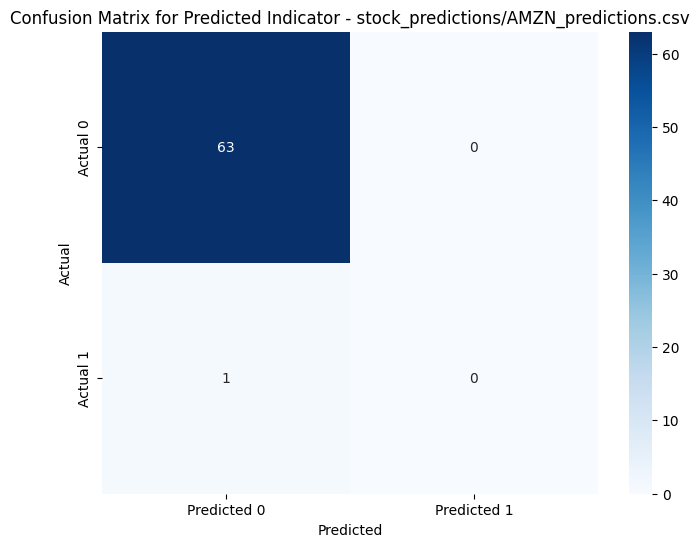

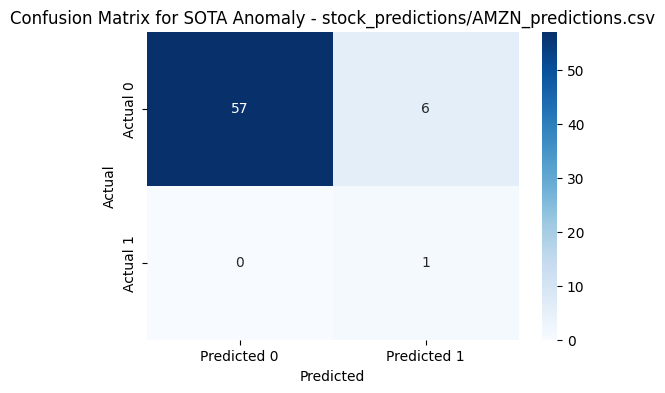

Skipping stock_predictions/MSFT_predictions.csv: Required columns not found.


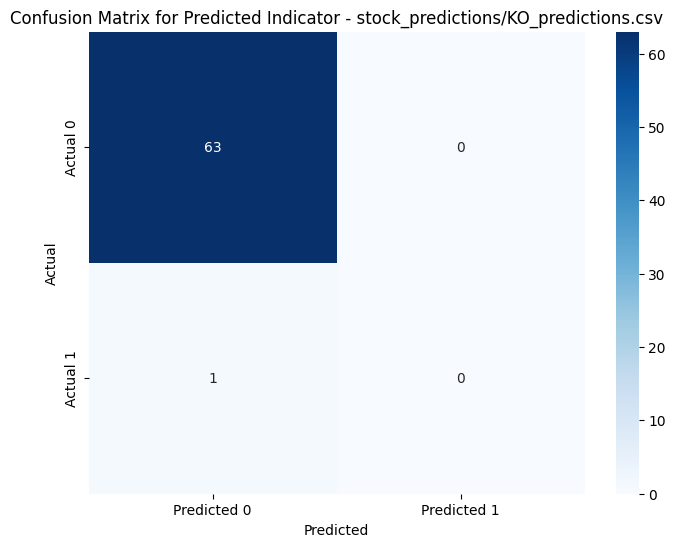

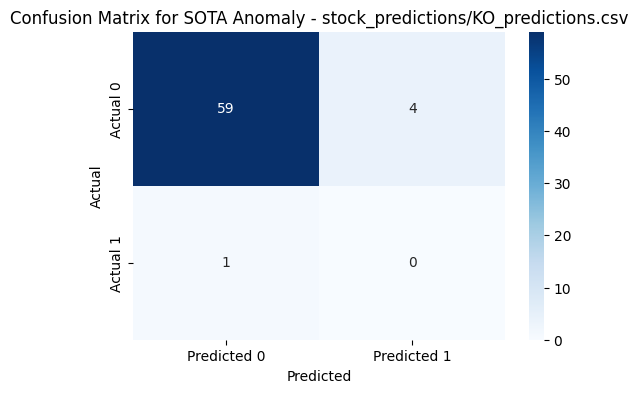

Skipping stock_predictions/AAPL_predictions.csv: Required columns not found.


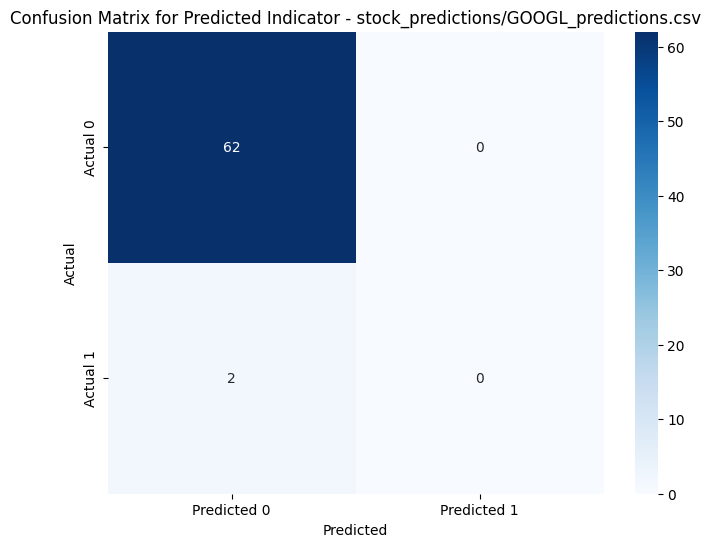

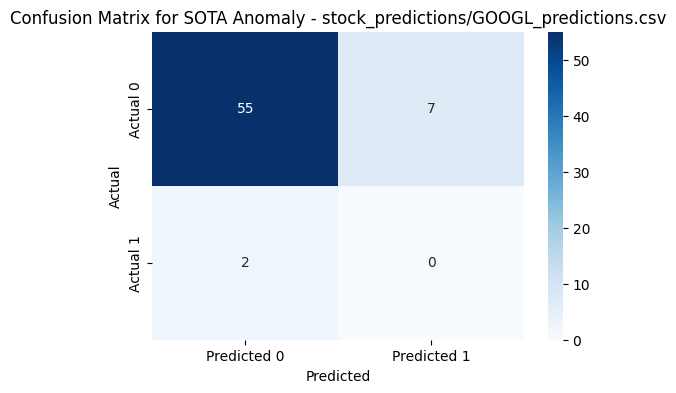

In [19]:
# prompt: generate a confusion matrix for the predictions

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Directory containing your CSV files
DIRECTORY_PATH = "stock_predictions"

# List all CSV files in the directory
csv_files = glob.glob(os.path.join(DIRECTORY_PATH, "*.csv"))

for csv_file in csv_files:
    # Read the CSV into a DataFrame
    df = pd.read_csv(csv_file)

    # Make sure the required columns exist in the CSV
    if "Indicator" not in df.columns or "Predicted Indicator" not in df.columns:
        print(f"Skipping {csv_file}: Required columns not found.")
        continue

    # Create the confusion matrix for 'Predicted Indicator'
    cm_predicted_indicator = confusion_matrix(df["Indicator"], df["Predicted Indicator"])

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_predicted_indicator, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Predicted 0", "Predicted 1"],
                yticklabels=["Actual 0", "Actual 1"])
    plt.title(f"Confusion Matrix for Predicted Indicator - {csv_file}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Create the confusion matrix for 'SOTA_Anomaly'
    cm_sota_anomaly = confusion_matrix(df["Indicator"], df["SOTA_Anomaly"])

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_sota_anomaly, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Predicted 0", "Predicted 1"],
                yticklabels=["Actual 0", "Actual 1"])
    plt.title(f"Confusion Matrix for SOTA Anomaly - {csv_file}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

## 6. Visualization

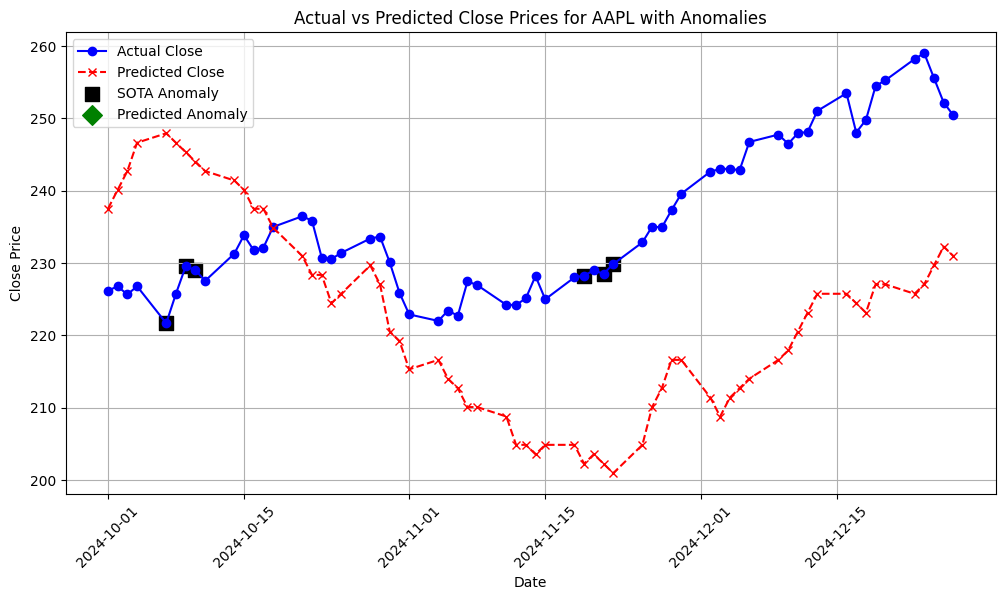

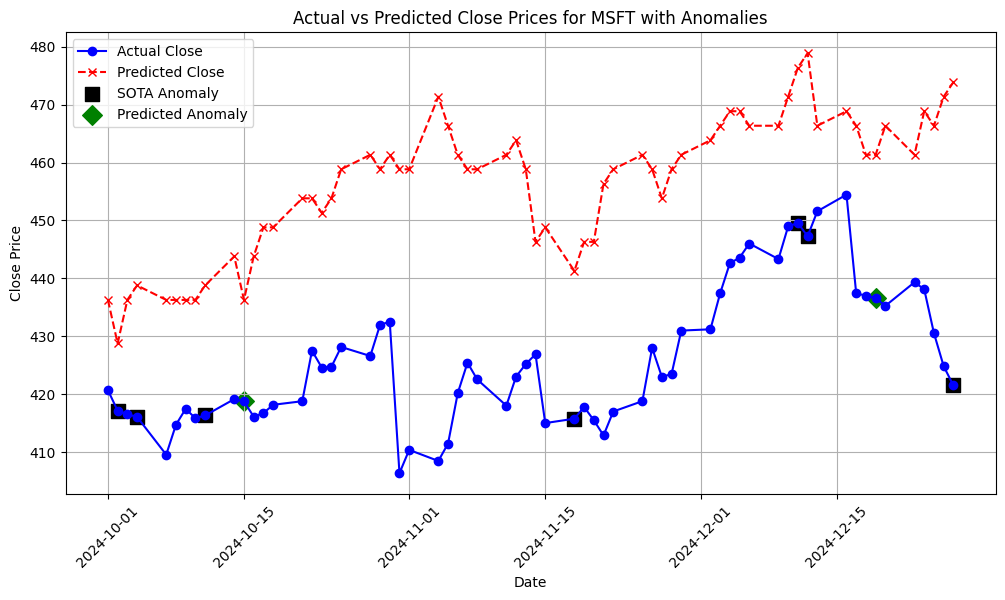

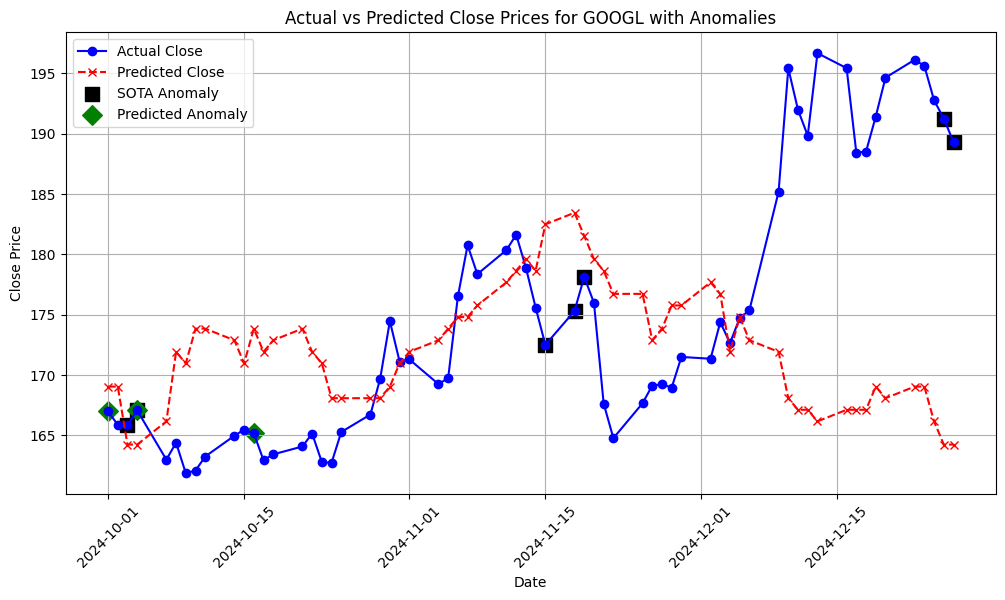

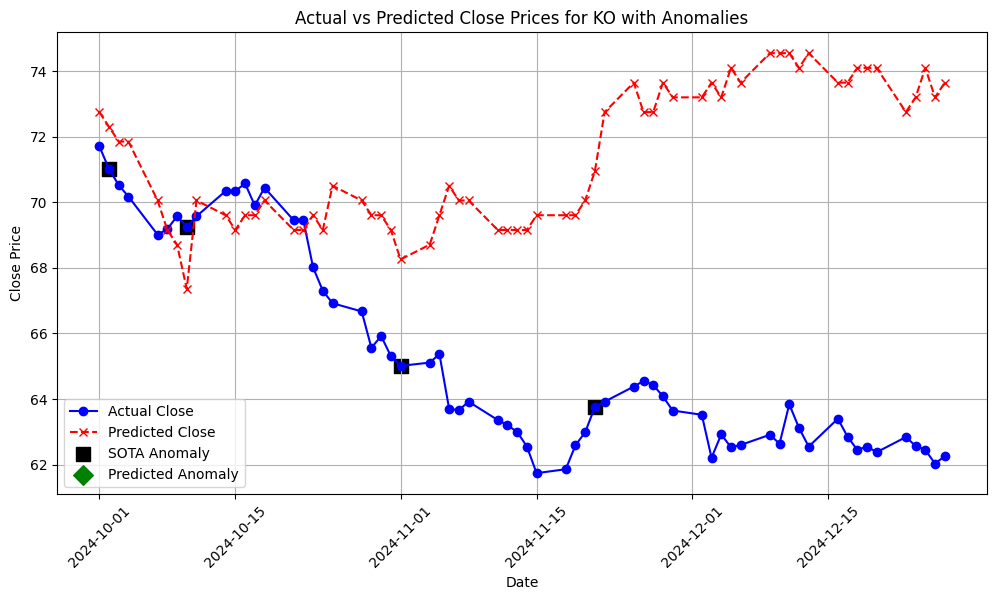

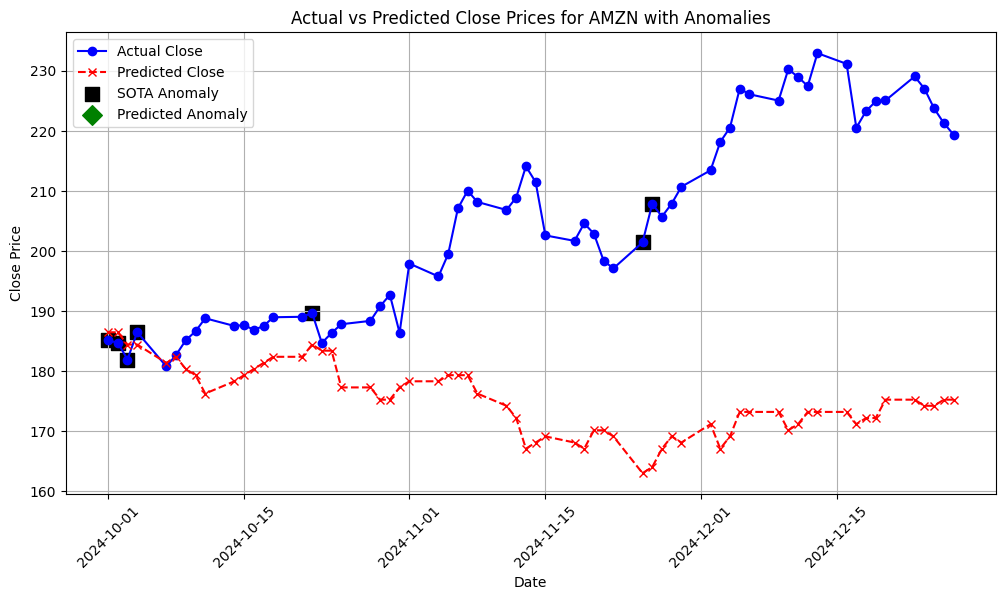

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_ticker_data(data, ticker):
    ticker_data = data[data['Ticker'] == ticker]
    
    # Convert Date column to datetime
    ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])
    
    # Plot actual vs predicted close prices
    plt.figure(figsize=(12, 6))
    plt.plot(ticker_data['Date'], ticker_data['Actual_Close'], label='Actual Close', marker='o', linestyle='-', color='blue')
    plt.plot(ticker_data['Date'], ticker_data['Predicted_Close'], label='Predicted Close', marker='x', linestyle='--', color='red')
    
    # Highlight anomalies detected by both models
    sota_anomalies = ticker_data[ticker_data['SOTA_prediction'] == 1]
    predicted_anomalies = ticker_data[ticker_data['Chronos_prediction'] == 1]
    
    ymin, ymax = plt.ylim()  # Get the current y-axis limits
    plt.vlines(predicted_anomalies['Date'], ymin, ymax, color='black', label='Predicted from SOTA', linestyles='dashed')
    plt.vlines(sota_anomalies['Date'], ymin, ymax, color='green', label='Predicted from Chronos', linestyles='dashed')

    # Formatting
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.title(f"Actual vs Predicted Close Prices for {ticker} with Anomalies")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.show()

# Plot data for the first 5 tickers
for ticker in tickers[:5]:
    data = pd.read_csv(f"stock_predictions/{ticker}_predictions.csv")
    data['Ticker'] = ticker  # Add the 'Ticker' column
    plot_ticker_data(data, ticker)
